<a href="https://colab.research.google.com/github/JoseAaronE/FisicaComputacional/blob/master/Evaluacion1/Evalucaion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Primera evaluación 

Esquivel Ovilla José Aarón 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
#agregamos esta biblioteca que tiene que ver con la prueba de Dickey-Fuller
from statsmodels.tsa.stattools import adfuller
#warning de que las cosas van a cambiar 
import pandas.util.testing as tm
#usaremos esto para el método de ARIMA 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMAResults

In [ ]:
#nombre de la variable 
url="https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_mlo_DailyData.txt"
#leemos el archivo
df=pd.read_csv(url,encoding='cp1251', sep='\s+', header=None, skiprows=151, skipfooter=1, engine='python')

#Borramos primera fila en x
df = df.drop(0,axis=0)

df["Fecha"] = df[3] + "/" + df[2]+"/"+ df[1]
#Hacemos que Fecha sea un tiempo
df["Fecha"] = pd.to_datetime(df["Fecha"],dayfirst=True,errors ='coerce')
df["Año"] = df["Fecha"].dt.year
df["Mes"] = df["Fecha"].dt.month
df["Dia"] = df["Fecha"].dt.day
df = df.set_index("Fecha")


#borramos las columnas que no nos interesan, pueden ser más 
df = df.drop(range(0, 8),axis=1)
df = df.drop(range(9, 17),axis=1)

#Eliminamos el valor de -999.99 por NAN usando np.nan
df=df.replace(to_replace="-999.99", value= np.nan, regex=True)

#Convertir a número flotante o numérico los valores de nuestras variables
#8 columna de value 
df[8] = df[8].astype(float)


df.columns=["Value","Año","Mes","Dia"]

#Construimos la columna Fecha combinando las columnas 'year', 'month', y 'day'. 
df.head(15)



,Value,Año,Mes,Dia
Fecha,,,,
1973-01-01,NaN,1973,1,1
1973-01-02,NaN,1973,1,2
1973-01-03,NaN,1973,1,3
1973-01-04,NaN,1973,1,4
1973-01-05,NaN,1973,1,5
1973-01-06,NaN,1973,1,6
1973-01-07,NaN,1973,1,7
1973-01-08,NaN,1973,1,8
1973-01-09,NaN,1973,1,9


In [ ]:
#Contruimos un nuevo dataframe con el rango de años de 1980 hasta fin del 2019

df_39 = df[(df['Año'] >= 1980) & (df['Año'] < 2019)].copy()
df_39.ffill(axis = 0 , inplace= True) 



df_39.head()

,Value,Año,Mes,Dia
Fecha,,,,
1980-01-01,337.85,1980,1,1
1980-01-02,337.32,1980,1,2
1980-01-03,337.75,1980,1,3
1980-01-04,337.70,1980,1,4
1980-01-05,337.65,1980,1,5


Análisis de la Serie de Tiempo.

In [ ]:
#definimos una función para hacer la prueba de Dickey-Fuller:
#probamos la estacionaridad
def test_stationarity(df_ts):

   #Determinamos las Estadísticas de promedios móviles de 365 
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 

    # tamaño de la gráfica 
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    #graficamos la serie 
    plt.plot(df_ts, color='blue',label='Original')
    #graficamos el promedio movil 
    plt.plot(rolmean, color='red', label='Rolling Mean')
    #graficamos la desviación estandar 
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')

    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    #agragamos una malla
    sns.set_style('whitegrid')
    
    plt.show()
 
    #Realizamos la Prueba Aumentada de Dickey-Fuller a nuestra serie de tiempo 
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


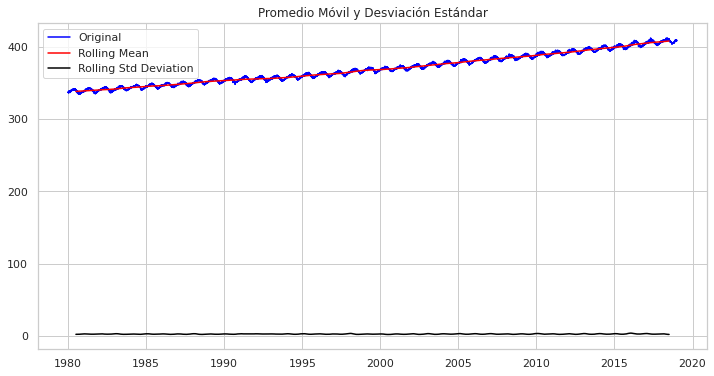

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                    -1.155189
p-value                            0.692569
#Lags Used                        42.000000
Number of Observations Used    14202.000000
Critical Value (1%)               -3.430811
Critical Value (5%)               -2.861744
Critical Value (10%)              -2.566878
dtype: float64


In [ ]:
ts_test_39 = df_39['Value']
#se la damos como argumento a la prueba 
test_stationarity(ts_test_39)


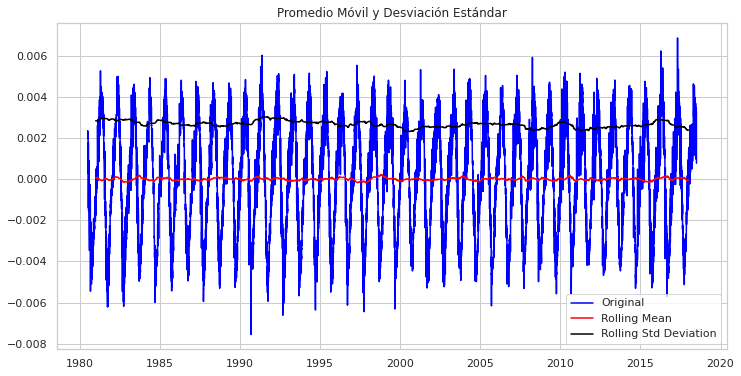

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.385363e+01
p-value                        6.931864e-26
#Lags Used                     4.200000e+01
Number of Observations Used    1.383800e+04
Critical Value (1%)           -3.430823e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [ ]:
#Podemos notar que nuestro valor de p=0.69 es mayor que 0.05 por lo que haremos modificaciones para poder bajar el valor de p 
#seleccionamos la función de logaritmo 
ts_test_log = np.log10(ts_test_39)

#calculamos el promedio móvil con con ventana de 365 días 
moving_avg = ts_test_log.rolling(365, center=True).mean()

ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()
#probamos la estacionaridad 
test_stationarity(ts_test_log_moving_ave_diff)

#Podemos ver que ahora el valor de p nos da menor a 0.05 

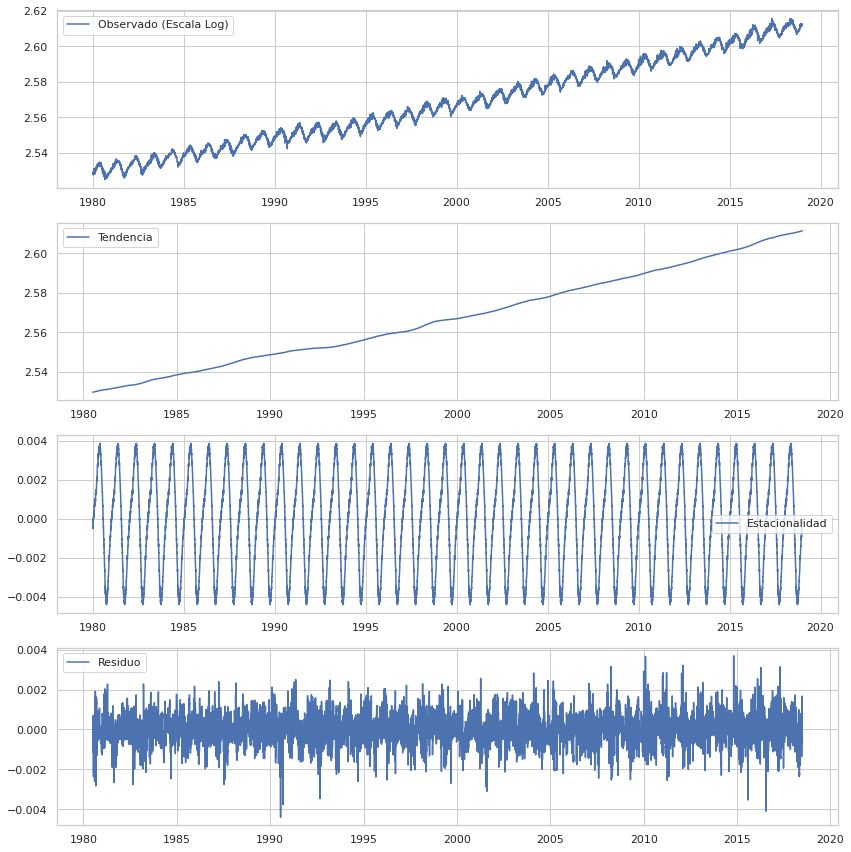

In [ ]:
# Método de descomposición 

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

#podemos ver que va tendiendo aser una linea recta y que va creciendo, por lo que podemos decir que el CO2 va aumentando con respecto al tiempo 
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

#Se puede notar que es un poco uniforme el comportamiento de la estacionalidad 
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

#Podemos ver que el residuo no varia mucho en le rango 
plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

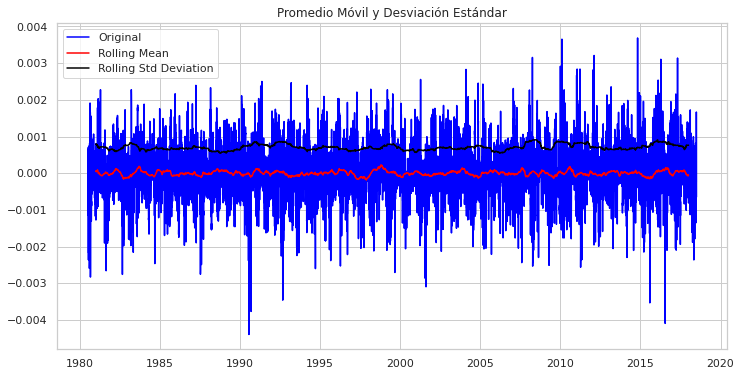

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.847383e+01
p-value                        2.137999e-30
#Lags Used                     2.200000e+01
Number of Observations Used    1.385800e+04
Critical Value (1%)           -3.430822e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [ ]:
#Probamos si la serie residuo es estacionaria
ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)


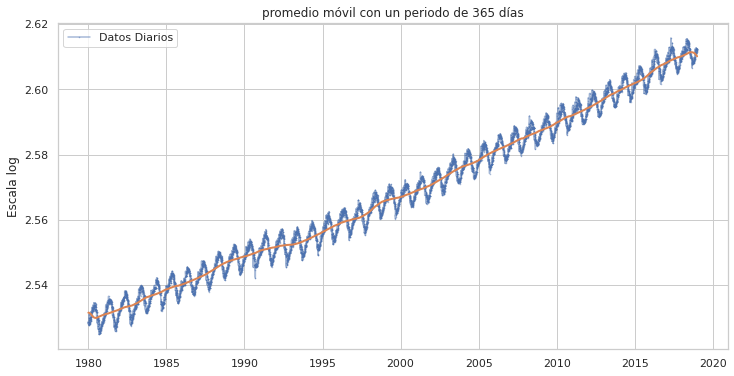

In [ ]:
#Podemos ver que la serie residuo si es estacionaria con un valor de p=2.13e-30
#Calculamos el promedio móvil con un periodo de 365 días 

moving_avg = ts_test_log.rolling(365, center=True,min_periods=1).mean()
#Hacemos la gráfica 
fig, ax = plt.subplots()
ax.plot(ts_test_log, marker='.', markersize=1, linestyle='-', alpha=0.5, label='Datos Diarios')
ax.plot(moving_avg, linewidth=2)
    
ax.legend()
ax.set_ylabel("Escala log")
ax.set_title('promedio móvil con un periodo de 365 días');

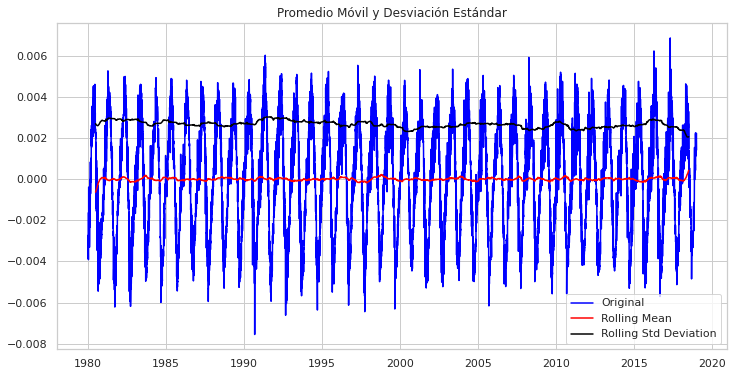

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.424214e+01
p-value                        1.531162e-26
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [ ]:
#definimos un nuevo dataframe 
ts_dif = ts_test_log - moving_avg 
ts_dif.dropna(inplace=True)
#probamos la estacioaridad 
test_stationarity(ts_dif)

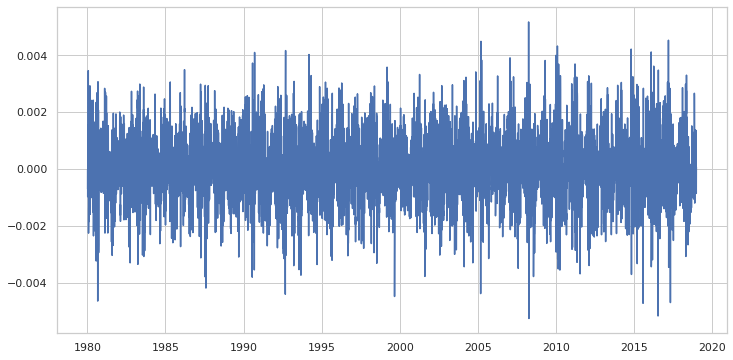

In [ ]:
#serie estacionaria usando la función de diferenciación shift con un periodo de 7 días
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

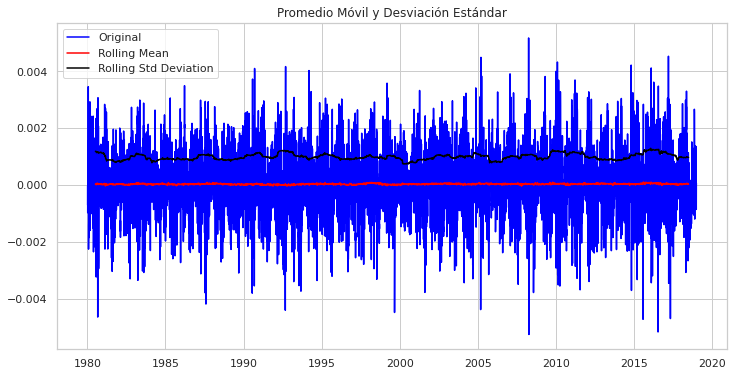

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.876005e+00
p-value                        3.881021e-17
#Lags Used                     4.200000e+01
Number of Observations Used    1.419500e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [ ]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


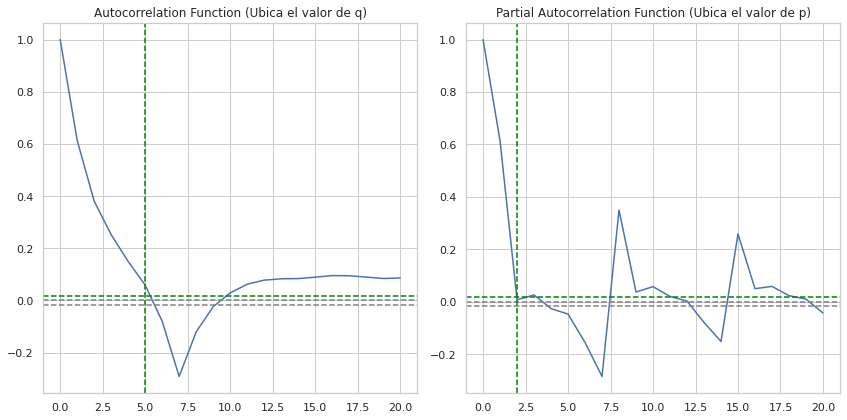

In [ ]:
#Modelo ARIMA de la serie ts_test_log_diff
lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=5, linestyle='--', color='green')
sns.set_style('whitegrid')
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
sns.set_style('whitegrid')
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                14244
Model:                 ARIMA(2, 1, 0)   Log Likelihood               85371.167
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -170734.334
Time:                        01:34:15   BIC                        -170704.077
Sample:                    01-02-1980   HQIC                       -170724.270
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.874e-06   3.53e-06      1.665      0.096   -1.04e-06    1.28e-05
ar.L1.D.Value    -0.2427      0.008    -29.505      0.000      -0.259      -0.227
ar.L2.D.Value    -0.1909      0.008    -

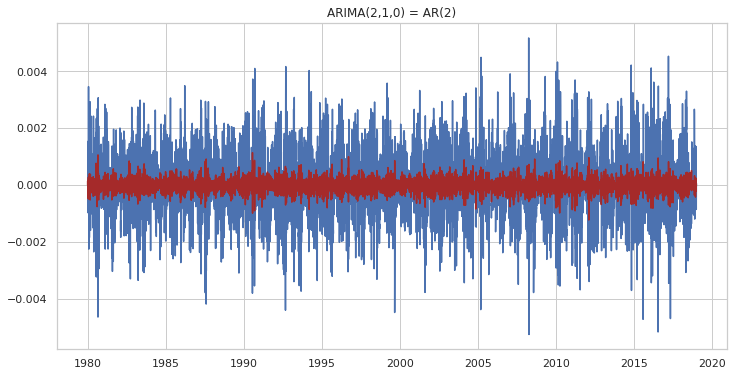

In [ ]:
#Criterio de Información de Akaike (AIC), podemos ver que el valor de q=5 y p=2

#Modelo AR (p)
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                14244
Model:                 ARIMA(0, 1, 4)   Log Likelihood               85673.670
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -171335.339
Time:                        01:34:17   BIC                        -171289.955
Sample:                    01-02-1980   HQIC                       -171320.243
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.874e-06   2.09e-06      2.815      0.005    1.78e-06    9.96e-06
ma.L1.D.Value    -0.2999      0.008    -35.821      0.000      -0.316      -0.284
ma.L2.D.Value    -0.1855      0.009    -

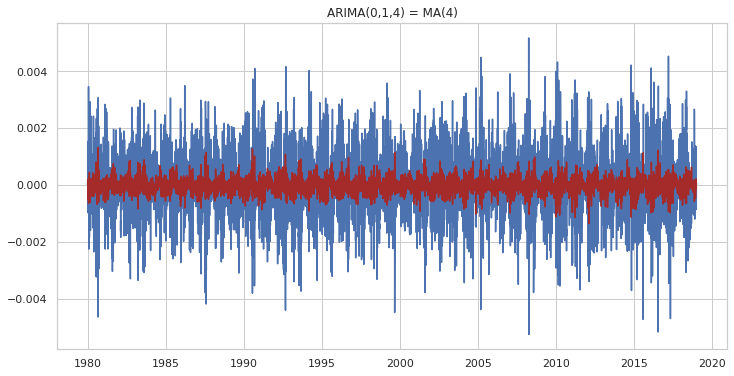

In [ ]:
#Modelo MA (q)
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                14244
Model:                 ARIMA(2, 1, 5)   Log Likelihood               85666.143
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -171314.286
Time:                        01:34:29   BIC                        -171246.209
Sample:                    01-02-1980   HQIC                       -171291.642
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.874e-06    2.1e-06      2.799      0.005    1.76e-06    9.99e-06
ar.L1.D.Value     0.3253        nan        nan        nan         nan         nan
ar.L2.D.Value     0.2991        nan     

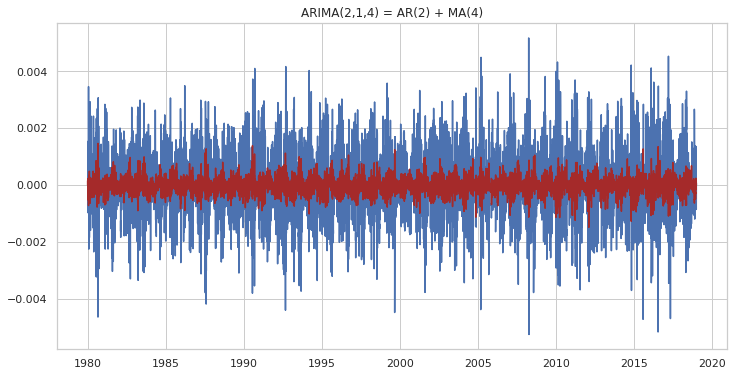

In [ ]:
#Modelo ARIMA (p,d,q)
model = ARIMA(ts_test_log, order=(2,1,5), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [ ]:
#Contrasta la serie observada de concentraciones de CO2 contra la construida por el modelo ARIMA.


In [ ]:
#Calculamos el error RMSE
#El mejor método para el AIC fue el de AR 
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_AR_diff)


Fecha
1980-01-02    0.000006
1980-01-03    0.000146
1980-01-04    0.000004
1980-01-05   -0.000082
1980-01-06    0.000036
                ...   
2018-12-27    0.000045
2018-12-28    0.000106
2018-12-29    0.000024
2018-12-30    0.000053
2018-12-31   -0.000032
Length: 14244, dtype: float64


In [ ]:
#Sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_AR_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff)
print(predictions_AR_log.head())
print(predictions_AR_log.tail())

Fecha
1980-01-01         NaN
1980-01-02    2.528048
1980-01-03    2.528741
1980-01-04    2.528535
1980-01-05    2.528385
dtype: float64
Fecha
2018-12-27    2.611789
2018-12-28    2.612106
2018-12-29    2.611641
2018-12-30    2.612137
2018-12-31    2.612381
dtype: float64


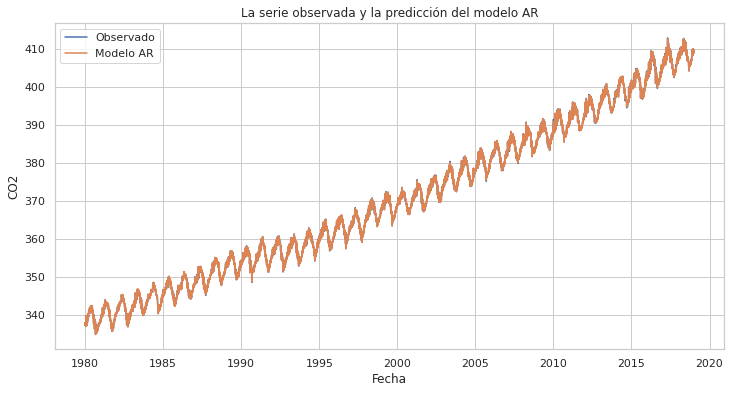

In [ ]:
# Regresamos a la escala de Temperatura original 
predictions_AR = 10**(predictions_AR_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_AR, label='Modelo AR');
plt.xlabel('Fecha')
plt.ylabel("CO2")
plt.title("La serie observada y la predicción del modelo AR")
plt.legend(loc='best');

In [ ]:
# Calculamos el RMSE 
RMSE = np.sqrt(np.mean((predictions_AR - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.14895510424805775


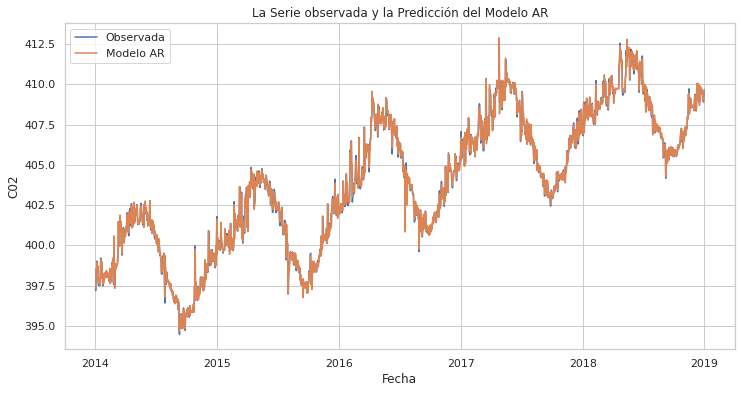

In [ ]:
#contrasta los 5 últimos años de la Serie de CO2 y el modelo AR para ver mas a detalles el modelo.
ts_test_last = ts_test.tail(1825)
predictions_AR_last = predictions_AR.tail(1825)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_AR_last, label='Modelo AR');
plt.xlabel('Fecha')
plt.ylabel('C02')
plt.title('La Serie observada y la Predicción del Modelo AR')
plt.legend(loc='best');
